In [1]:
import numpy as np
from numpy import random
import random
import matplotlib.pyplot as plt
from scipy.signal import cwt,ricker
from scipy import stats
from sklearn.preprocessing import StandardScaler,normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
import os
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.optimizers
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.models import load_model
from tensorflow.keras.layers import Flatten,concatenate,Layer,Dense,LSTM,Activation,MaxPooling2D,Dropout,Conv2D,BatchNormalization,Reshape,UpSampling2D,ZeroPadding2D
#import nibabel as nib
#import pydicom as dicom
#from pydicom.pixel_data_handlers.util import apply_voi_lut
#import tensorflow_io as tfio
import radiomics
from radiomics.featureextractor import RadiomicsFeatureExtractor
import SimpleITK as sitk
import pandas as pd


2022-08-07 06:44:15.957587: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# Training

In [4]:
#TF_ENABLE_ONEDNN_OPTS=0

In [5]:
dict = './covid19/kcv/'

# Function takes a list of folders, extract features from it, change the extractor inside function and the return dictionary
# to run exactly which feature, the key of the return dictionary can be found in mask.ipy and also listed in pyradiomics library
def LoadDataFromImages(foldernames):
    input_array = []
    #output_array=[]
    o1=[]
    o2=[]
    o3=[]
    o4=[]
    o5=[]

    extractor = RadiomicsFeatureExtractor()
    # Disable all classes except firstorder
    extractor.disableAllFeatures()
    extractor.enableFeaturesByName(firstorder=['Skewness'])  # change here to extract
    extractor.enableFeaturesByName(glcm=['Autocorrelation'])
    extractor.enableFeaturesByName(glrlm=['GrayLevelVariance','RunLengthNonUniformity'])
    extractor.enableFeaturesByName(glszm=['SizeZoneNonUniformity'])

    for i in foldernames:
        files  = sorted(os.listdir(dict + i))
        for j in files:
            im = sitk.ReadImage(dict + i +'/' + j)
            
            # reshape and fill the input array
            input_array.append(sitk.GetArrayFromImage(im).reshape(512,512,1))
            
            ma_arr = np.ones(im.GetSize()[::-1])  # reverse the order as image is xyz, array is zyx
            ma = sitk.GetImageFromArray(ma_arr)
            ma.CopyInformation(im)  # Copy geometric info
            
            # extract features and fill the output array
            features = extractor.execute(im, ma)
            
            #output_array.append(features['original_ngtdm_Strength'])  # change here to extract
            o1.append(features['original_firstorder_Skewness'])
            o2.append(features['original_glcm_Autocorrelation'])
            o3.append(features['original_glrlm_GrayLevelVariance'])
            o4.append(features['original_glrlm_RunLengthNonUniformity'])
            o5.append(features['original_glszm_SizeZoneNonUniformity'])

            
    return input_array,o1,o2,o3,o4,o5

            

In [6]:
input_array, o1,o2,o3,o4,o5 = LoadDataFromImages(["pos", "neg"])

In [7]:
input_array = np.array(input_array)
o1 = np.array(o1)
o2 = np.array(o2)
o3 = np.array(o3)
o4 = np.array(o4)
o5 = np.array(o5)



In [8]:
np.save("input_arr.npy",input_array)
np.save("o1ar.npy",o1)
np.save("o2ar.npy",o2)
np.save("o3ar.npy",o3)
np.save("o4ar.npy",o4)
np.save("o5ar.npy",o5)

In [55]:
skew1 = load_model('SizeZoneNonUniformity1.h5')

2/2 [==============================] - 0s 6ms/step


Text(0.5, 1.0, 'SizeZoneNonUniformity K1 set Performance')

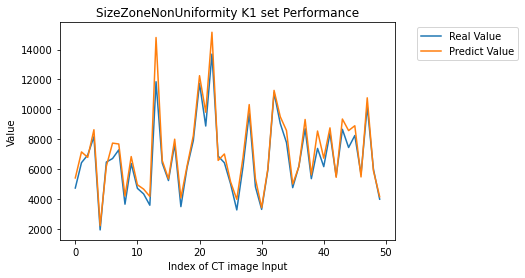

In [57]:

plt.plot(range(50),feature5_test[0][50:100] ,label='Real Value')
plt.plot(range(50),skew1.predict(testgroup[0][50:100])  ,label='Predict Value')
plt.xlabel("Index of CT image Input")
plt.ylabel("Value")
plt.legend(bbox_to_anchor=(1.05, 1),loc='upper left')
plt.title('SizeZoneNonUniformity K1 set Performance')


In [98]:
# np.save("input_arr_test.npy",input_array)
# np.save("o1ar_test.npy",o1)
# np.save("o2ar_test.npy",o2)
# np.save("o3ar_test.npy",o3)
# np.save("o4ar_test.npy",o4)
# np.save("o5ar_test.npy",o5)

In [104]:
# np.save("input_arr_finet.npy",input_array)
# np.save("o1ar_finet.npy",o1)
# np.save("o2ar_finet.npy",o2)
# np.save("o3ar_finet.npy",o3)
# np.save("o4ar_finet.npy",o4)
# np.save("o5ar_finet.npy",o5)

# Load the Training and Testing Data

In [2]:

# label index 0 is positive, 1 is negative
class_names = ['pos', 'neg']
dict = './covid19/kcv/'

In [3]:

def load_training():
    trainingdata = []
    for i in class_names:
        path = os.path.join(dict, i)
        label_num = class_names.index(i)
        for j in sorted(os.listdir(path)):
            img = sitk.ReadImage(dict + i +'/' + j)
            trainingdata.append([sitk.GetArrayFromImage(img).reshape(512,512,1),label_num])
            
    return trainingdata
    
            
    

In [4]:
data= load_training()

In [5]:
len(data)

8000

In [6]:
X =[]
Y =[]

for trainingx, label in data:
 
    X.append(trainingx)
    Y.append(label)


In [7]:
# load input images and output features:
#data = np.load('input_arr.npy')

feature_arr1 = np.load('o1ar.npy')  # original_firstorder_Skewness
feature_arr2 = np.load('o2ar.npy')  # original_glcm_Autocorrelation
feature_arr3 = np.load('o3ar.npy')  # original_glrlm_GrayLevelVariance
feature_arr4 = np.load('o4ar.npy')  # original_glrlm_RunLengthNonUniformity
feature_arr5 = np.load('o5ar.npy')  # original_glszm_SizeZoneNonUniformity



In [8]:
# apply k fold cross validation, k=10
kfold = KFold(10,shuffle=True,random_state=1)

traingroup = []
testgroup=[]

feature1_train= []
feature2_train= []
feature3_train= []
feature4_train= []
feature5_train= []

feature1_test= []
feature2_test= []
feature3_test= []
feature4_test= []
feature5_test= []

output_label_train = []
output_label_test = []




# split data to 10 train and test set
for train, test in kfold.split(X):
    #print('train: %s, test: %s' % (train, test))
    per_train_group = []
    per_test_group=[]
    
    per_feature1_train = []
    per_feature2_train = []
    per_feature3_train = []
    per_feature4_train = []
    per_feature5_train = []
    
    per_feature1_test = []
    per_feature2_test = []
    per_feature3_test = []
    per_feature4_test = []
    per_feature5_test = []
    
    per_label_train =[]
    per_label_test = []
    
    for i in train:
        per_train_group.append(X[i])
        per_label_train.append(Y[i])
        per_feature1_train.append(feature_arr1[i])
        per_feature2_train.append(feature_arr2[i])
        per_feature3_train.append(feature_arr3[i])
        per_feature4_train.append(feature_arr4[i])
        per_feature5_train.append(feature_arr5[i])
    for i in test:
        per_test_group.append(X[i])
        per_label_test.append(Y[i])
        per_feature1_test.append(feature_arr1[i])
        per_feature2_test.append(feature_arr2[i])
        per_feature3_test.append(feature_arr3[i])
        per_feature4_test.append(feature_arr4[i])
        per_feature5_test.append(feature_arr5[i])
        
        
    traingroup.append(per_train_group)
    testgroup.append(per_test_group)
    
    feature1_train.append(per_feature1_train)
    feature2_train.append(per_feature2_train)
    feature3_train.append(per_feature3_train)
    feature4_train.append(per_feature4_train)
    feature5_train.append(per_feature5_train)
    
    feature1_test.append(per_feature1_test)
    feature2_test.append(per_feature2_test)
    feature3_test.append(per_feature3_test)
    feature4_test.append(per_feature4_test)
    feature5_test.append(per_feature5_test)
    
    output_label_train.append(per_label_train)
    output_label_test.append(per_label_test)

        

In [9]:
#convert them into numpy arrays
traingroup = np.array(traingroup)
testgroup= np.array(testgroup)

feature1_train= np.array(feature1_train)
feature2_train= np.array(feature2_train)
feature3_train= np.array(feature3_train)
feature4_train= np.array(feature4_train)
feature5_train= np.array(feature5_train)

feature1_test= np.array(feature1_test)
feature2_test= np.array(feature2_test)
feature3_test= np.array(feature3_test)
feature4_test= np.array(feature4_test)
feature5_test= np.array(feature5_test)

output_label_train = np.array(output_label_train)
output_label_test = np.array(output_label_test)


In [10]:
# np.save('t1',traingroup)
# np.save('t2',testgroup)

# np.save('t3',feature1_train)
# np.save('t4',feature2_train)
# np.save('t5',feature3_train)
# np.save('t6',feature4_train)
# np.save('t7',feature5_train)

# np.save('t8',feature1_test)
# np.save('t9',feature2_test)
# np.save('t10',feature3_test)
# np.save('t11',feature4_test)
# np.save('t12',feature5_test)

# np.save('t13',output_label_train)
# np.save('t14',output_label_test)

In [2]:
traingroup = np.load('t1.npy')
testgroup= np.load('t2.npy')

feature1_train= np.load('t3.npy')
feature2_train= np.load('t4.npy')
feature3_train= np.load('t5.npy')
feature4_train= np.load('t6.npy')
feature5_train= np.load('t7.npy')

feature1_test= np.load('t8.npy')
feature2_test= np.load('t9.npy')
feature3_test= np.load('t10.npy')
feature4_test= np.load('t11.npy')
feature5_test= np.load('t12.npy')

output_label_train = np.load('t13.npy')
output_label_test = np.load('t14.npy')

In [60]:
# clear GPU session
tf.keras.backend.clear_session()

In [73]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

2022-08-06 06:41:33.317428: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10794 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0000:0b:00.0, compute capability: 3.7


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# Regular Neural network with Random initialization

In [27]:
# creating a simple Network
def MakeModel(modelname):
    input_layer = keras.Input(shape=(512,512,1))
    #x = Flatten()(input_layer)
    #x = BatchNormalization(axis=1)(x)
    x = Conv2D(64,(3,3), activation='relu')(input_layer)
    pool1 = MaxPooling2D(pool_size=(2, 2))(x)
    x1 = Conv2D(64,(3,3), activation='relu')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(x1)


    flat = Flatten()(pool2)
    d1 = Dense(164, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(flat)
    out = Dense(2, activation = 'softmax', name= modelname)(d1)

    model = keras.Model(input_layer, out, name= modelname)
    
    return model

In [28]:
RNNModel = MakeModel('RNNModel')

In [29]:
RNNModel.summary()

Model: "RNNModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 510, 510, 64)      640       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 255, 255, 64)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 253, 253, 64)      36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 1016064)           0  

In [30]:
RNNModel.compile(optimizer=tf.keras.optimizers.Adam(
 learning_rate= 0.0001
),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy']
                   )

In [31]:
filename='history_rnnf.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

In [32]:
history_rnn = RNNModel.fit(traingroup[9], output_label_train[9], 
                validation_data=([testgroup[9],output_label_test[9]]), 
                batch_size=32,
                epochs=10,
                          callbacks=[history_logger])


Epoch 1/10
225/225 [==============================] - 24s 107ms/step - loss: 33.8205 - accuracy: 0.9515 - val_loss: 1.6781 - val_accuracy: 0.9650
Epoch 2/10
225/225 [==============================] - 24s 105ms/step - loss: 0.0429 - accuracy: 0.9979 - val_loss: 0.0442 - val_accuracy: 0.9950
Epoch 3/10
225/225 [==============================] - 24s 105ms/step - loss: 0.0305 - accuracy: 0.9975 - val_loss: 0.1082 - val_accuracy: 0.9937
Epoch 4/10
225/225 [==============================] - 24s 105ms/step - loss: 0.0019 - accuracy: 0.9997 - val_loss: 0.1104 - val_accuracy: 0.9925
Epoch 5/10
225/225 [==============================] - 24s 105ms/step - loss: 1.8106e-05 - accuracy: 1.0000 - val_loss: 0.1340 - val_accuracy: 0.9925
Epoch 6/10
225/225 [==============================] - 24s 105ms/step - loss: 5.1326e-10 - accuracy: 1.0000 - val_loss: 0.1340 - val_accuracy: 0.9925
Epoch 7/10
225/225 [==============================] - 24s 105ms/step - loss: 5.1326e-10 - accuracy: 1.0000 - val_loss: 0.

In [30]:
RNNModel.save('rnnSample.h5')

# Simple models with raw features

In [10]:
features_train = np.stack((feature1_train,feature2_train,feature3_train,feature4_train, feature5_train),axis=2)
features_test = np.stack((feature1_test,feature2_test,feature3_test,feature4_test, feature5_test),axis=2)

In [11]:
features_train.shape

(10, 7200, 5)

In [121]:


def MakeModel(modelname):
    input_layer = keras.Input(shape=(5))

    
    #x = Flatten()(n_d)
    #x = BatchNormalization(axis=1)(x)
    x = Dense(5096, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(input_layer)
    x = Dense(5096, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(5096, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(5096, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(5096, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(5096, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(2048, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(2048, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(2048, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(2048, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(2048, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(2048, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(1024, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(1024, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(1024, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)
    x = Dense(1024, activation='relu')(x)
    x = Dense(1024, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal())(x)


    out = Dense(2, activation = 'softmax', name= modelname)(x)

    model = keras.Model(input_layer, out, name= modelname)
    
    return model

In [122]:
rawFeatureModel = MakeModel('rawFeatures')

In [123]:
rawFeatureModel.summary()

Model: "rawFeatures"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 5)]               0         
                                                                 
 dense_137 (Dense)           (None, 5096)              30576     
                                                                 
 dense_138 (Dense)           (None, 5096)              25974312  
                                                                 
 dense_139 (Dense)           (None, 5096)              25974312  
                                                                 
 dense_140 (Dense)           (None, 5096)              25974312  
                                                                 
 dense_141 (Dense)           (None, 5096)              25974312  
                                                                 
 dense_142 (Dense)           (None, 5096)              

In [124]:
filename='history_rawfeaturerf.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

In [125]:
rawFeatureModel.compile(optimizer=tf.keras.optimizers.Adam(
 learning_rate= 0.0001
),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
                )

In [126]:
history_rawFeature= rawFeatureModel.fit(features_train[9], output_label_train[9], 
                validation_data=([features_test[9],output_label_test[9]]), 
                batch_size=32,
                epochs=10,
                                       callbacks=[history_logger])

Epoch 1/10
225/225 [==============================] - 4s 15ms/step - loss: 0.9178 - accuracy: 0.8739 - val_loss: 0.2458 - val_accuracy: 0.8975
Epoch 2/10
225/225 [==============================] - 3s 12ms/step - loss: 0.2060 - accuracy: 0.9178 - val_loss: 0.3256 - val_accuracy: 0.8600
Epoch 3/10
225/225 [==============================] - 3s 12ms/step - loss: 0.2654 - accuracy: 0.9064 - val_loss: 0.3754 - val_accuracy: 0.8587
Epoch 4/10
225/225 [==============================] - 3s 12ms/step - loss: 0.2602 - accuracy: 0.9036 - val_loss: 0.2929 - val_accuracy: 0.8900
Epoch 5/10
225/225 [==============================] - 3s 12ms/step - loss: 0.2149 - accuracy: 0.9192 - val_loss: 0.2603 - val_accuracy: 0.8963
Epoch 6/10
225/225 [==============================] - 3s 12ms/step - loss: 0.1956 - accuracy: 0.9271 - val_loss: 0.2515 - val_accuracy: 0.8925
Epoch 7/10
225/225 [==============================] - 3s 12ms/step - loss: 0.2070 - accuracy: 0.9287 - val_loss: 0.2340 - val_accuracy: 0.9075

In [36]:
rawFeatureModel.save('RawFeature.h5')

# FINs

In [2]:
#             o1.append(features['original_firstorder_Skewness'])
#             o2.append(features['original_glcm_Autocorrelation'])
#             o3.append(features['original_glrlm_GrayLevelVariance'])
#             o4.append(features['original_glrlm_RunLengthNonUniformity'])
#             o5.append(features['original_glszm_SizeZoneNonUniformity'])

In [31]:
inp = np.load('t1.npy')
oup = np.load('t5.npy')

In [32]:
input_array = inp[0]
output_array = oup[0]

In [33]:
base_model =  load_model("radiomics_glrlm_GrayLevelVariance.h5")

In [34]:
base_model.summary()

Model: "GrayLevelVariance"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 512, 512, 1)]     0         
                                                                 
 flatten_19 (Flatten)        (None, 262144)            0         
                                                                 
 batch_normalization_19 (Bat  (None, 262144)           1048576   
 chNormalization)                                                
                                                                 
 dense_126 (Dense)           (None, 32)                8388640   
                                                                 
 dense_127 (Dense)           (None, 32)                1056      
                                                                 
 dense_128 (Dense)           (None, 32)                1056      
                                                 

In [37]:
# how many layers for saving
newlayers = base_model.layers[8].output
n1 = Dense(32, activation='relu',name = '1')(newlayers)
out = Dense(1, activation='linear',name='2')(n1)
new_model = keras.Model(base_model.input, outputs = out)

In [38]:
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 512, 512, 1)]     0         
                                                                 
 flatten_19 (Flatten)        (None, 262144)            0         
                                                                 
 batch_normalization_19 (Bat  (None, 262144)           1048576   
 chNormalization)                                                
                                                                 
 dense_126 (Dense)           (None, 32)                8388640   
                                                                 
 dense_127 (Dense)           (None, 32)                1056      
                                                                 
 dense_128 (Dense)           (None, 32)                1056      
                                                           

In [40]:
for i in range(len(base_model.layers)): 
    keras.layers.trainable = True   # True--> fine tine, False-->frozen

In [41]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir='logs/GrayLevelVariance1', histogram_freq=1, profile_batch = 0
)

#https://github.com/tensorflow/tensorflow/issues/39755

In [42]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(
 learning_rate= 0.001
), loss="mse")

In [47]:
new_model.fit(input_array, output_array, 
              epochs=20, 
          batch_size=64,
                shuffle=True,
              callbacks = tensorboard_callback
            )

Epoch 1/20
113/113 [==============================] - 2s 15ms/step - loss: 7.7080
Epoch 2/20
113/113 [==============================] - 1s 12ms/step - loss: 7.2464
Epoch 3/20
113/113 [==============================] - 1s 12ms/step - loss: 6.7146
Epoch 4/20
113/113 [==============================] - 1s 12ms/step - loss: 6.1829
Epoch 5/20
113/113 [==============================] - 1s 12ms/step - loss: 5.9244
Epoch 6/20
113/113 [==============================] - 1s 12ms/step - loss: 5.7315
Epoch 7/20
113/113 [==============================] - 1s 13ms/step - loss: 5.4710
Epoch 8/20
113/113 [==============================] - 2s 13ms/step - loss: 5.4298
Epoch 9/20
113/113 [==============================] - 1s 12ms/step - loss: 4.8115
Epoch 10/20
113/113 [==============================] - 1s 12ms/step - loss: 4.5115
Epoch 11/20
113/113 [==============================] - 1s 13ms/step - loss: 4.7637
Epoch 12/20
113/113 [==============================] - 1s 13ms/step - loss: 4.1802
Epoch 13/20
1

In [48]:
new_model.save("./GrayLevelVariance1.h5")

In [73]:
#Make the model using the Fins

# loading FINs
m1 = load_model('Skewness10.h5')
m2 = load_model('Autocorrelation10.h5')
m3 = load_model('GrayLevelVariance10.h5')
m4 = load_model('RunLengthNonUniformity10.h5')
m5 = load_model('SizeZoneNonUniformity10.h5')

m1._name = 'feature1'
m2._name = 'feature2'
m3._name = 'feature3'
m4._name = 'feature4'
m5._name = 'feature5'

def MakeModel(modelname):
    input_layer = keras.Input(shape=(512,512,1))
    
    l1 = m1(input_layer)
    l2 = m2(input_layer)
    l3 = m3(input_layer)
    l4 = m4(input_layer)
    l5 = m5(input_layer)
    
    n_d = concatenate([l1,l2
                       ,l3,l4
                       ,l5
                      ])
    #flat = Flatten()(n_d)

    x = Dense(128, activation='relu',kernel_initializer = tf.keras.initializers.GlorotNormal()
         ,name='x3')(n_d)

    out = Dense(2, activation = 'softmax', name= modelname)(x)

    model = keras.Model(input_layer, out, name= modelname)
    
    return model

In [74]:
FinModel = MakeModel('Fin')

In [75]:
FinModel.summary()

Model: "Fin"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 feature1 (Functional)          (None, 1)            17842561    ['input_12[0][0]']               
                                                                                                  
 feature2 (Functional)          (None, 1)            34669313    ['input_12[0][0]']               
                                                                                                  
 feature3 (Functional)          (None, 1)            9443585     ['input_12[0][0]']             

In [76]:
filename='history_finf.csv'
history_logger=tf.keras.callbacks.CSVLogger(filename, separator=",", append=True)

In [77]:
FinModel.compile(optimizer=tf.keras.optimizers.Adam(
 learning_rate= 0.0001
),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy']
                   )

In [78]:
history_fin = FinModel.fit(traingroup[9], output_label_train[9], 
                validation_data=([testgroup[9],output_label_test[9]]), 
                batch_size=32,
                epochs=10, callbacks=[history_logger])

Epoch 1/10
225/225 [==============================] - 6s 21ms/step - loss: 404.1031 - accuracy: 0.7744 - val_loss: 6.0893 - val_accuracy: 0.8425
Epoch 2/10
225/225 [==============================] - 4s 19ms/step - loss: 2.0987 - accuracy: 0.9290 - val_loss: 0.6831 - val_accuracy: 0.9400
Epoch 3/10
225/225 [==============================] - 4s 18ms/step - loss: 0.4562 - accuracy: 0.9613 - val_loss: 0.4355 - val_accuracy: 0.9737
Epoch 4/10
225/225 [==============================] - 4s 18ms/step - loss: 0.3585 - accuracy: 0.9663 - val_loss: 1.1059 - val_accuracy: 0.9538
Epoch 5/10
225/225 [==============================] - 4s 18ms/step - loss: 0.2488 - accuracy: 0.9782 - val_loss: 0.2734 - val_accuracy: 0.9825
Epoch 6/10
225/225 [==============================] - 4s 18ms/step - loss: 0.1354 - accuracy: 0.9856 - val_loss: 0.1918 - val_accuracy: 0.9850
Epoch 7/10
225/225 [==============================] - 4s 18ms/step - loss: 0.0835 - accuracy: 0.9914 - val_loss: 0.1617 - val_accuracy: 0.99

In [17]:
# hist_df = pd.DataFrame(history_fin.history) 
# hist_csv_file = 'history_fin.csv'
# with open(hist_csv_file, mode='w') as f:
#     hist_df.to_csv(f)

In [14]:
# the folder name by label
class_names = ['pos','neg']

# the image dictionary we are loading
dict = './covid19/kcv/'

def load_image( imageName ):
    trainingdata = []
    for i in class_names:
        path = os.path.join(dict, i)
        label_num = class_names.index(i)
        try:
            img = sitk.ReadImage(dict + i +'/' + imageName)
            trainingdata.append([sitk.GetArrayFromImage(img).reshape(512,512,1),label_num])
        except:
            pass
            
    return trainingdata

singleImage = load_image('Non-COVID-19_042.png')

image = singleImage[0][0]
label = singleImage[0][1]
image = np.array(image)
inputimage = image.reshape(1,512,512,1)

FinModel.predict(inputimage)

1/1 [==============================] - 0s 33ms/step


array([[5.6536526e-05, 9.9994349e-01]], dtype=float32)